# 🎯 Complete Feature Engineering Pipeline

**Objective**: Transform raw Airbnb data into optimized features for price prediction

**Pipeline Steps**:
1. **Setup & Data Loading**
2. **Feature Engineering** (all columns)
3. **Target Transformation** (log transformation)
4. **Feature Selection** (multiple methods)
5. **Visualization & Analysis**
6. **Save Final Dataset**


## 1. Setup & Imports


In [1]:
# Essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn components
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    OneHotEncoder, FunctionTransformer, MinMaxScaler, StandardScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.feature_selection import (
    SelectKBest, f_regression, mutual_info_regression
)
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

# Feature engineering
from feature_engine.encoding import RareLabelEncoder

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


## 2. Data Loading


In [2]:
# Load the cleaned datasets
train_path = '../data/processed/train.csv'
val_path = '../data/processed/val.csv'
test_path = '../data/processed/test.csv'

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

print(f"📊 Dataset Shapes:")
print(f"   • Train: {train_data.shape}")
print(f"   • Validation: {val_data.shape}")
print(f"   • Test: {test_data.shape}")

# Separate features and target
X_train = train_data.drop('price', axis=1)
y_train = train_data['price']

X_val = val_data.drop('price', axis=1)
y_val = val_data['price']

X_test = test_data.drop('price', axis=1)
y_test = test_data['price']

print(f"\n🎯 Original Features: {list(X_train.columns)}")
print(f"📈 Target Distribution: ${y_train.min():.0f} - ${y_train.max():.0f} (mean: ${y_train.mean():.0f})")

X_train.head()


📊 Dataset Shapes:
   • Train: (30949, 12)
   • Validation: (7738, 12)
   • Test: (9672, 12)

🎯 Original Features: ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
📈 Target Distribution: $10 - $10000 (mean: $152)


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Manhattan,Washington Heights,40.84996,-73.93937,Private room,5,1,2016-05-28,0.03,1,0
1,Manhattan,Chinatown,40.71610,-73.99828,Entire home/apt,2,43,2019-01-03,1.32,1,0
2,Queens,Elmhurst,40.73088,-73.87488,Entire home/apt,2,47,2019-06-27,4.18,1,315
3,Manhattan,Harlem,40.82396,-73.94388,Entire home/apt,5,81,2019-06-09,1.48,3,303
4,Queens,Queens Village,40.72085,-73.74960,Entire home/apt,2,33,2019-06-30,3.60,1,282


## 3. Feature Engineering

### 3.1 Neighbourhood Group Features


In [3]:
# Neighbourhood Group: Simple one-hot encoding (low cardinality)
ng_transformer = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1, replace_with='Other', n_categories=3)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Test the transformer
ng_features = ng_transformer.fit_transform(X_train[['neighbourhood_group']])
print(f"✅ Neighbourhood Group: {X_train['neighbourhood_group'].nunique()} → {ng_features.shape[1]} features")
print(f"   Categories: {list(X_train['neighbourhood_group'].unique())}")


✅ Neighbourhood Group: 5 → 4 features
   Categories: ['Manhattan', 'Queens', 'Brooklyn', 'Staten Island', 'Bronx']


### 3.2 Location Features (Latitude & Longitude)


In [4]:
# Location engineering: distance to Manhattan + clustering + keep original
def distance_to_manhattan(location_df):
    """Calculate distance to Manhattan center using Haversine formula"""
    # Manhattan center coordinates
    manhattan_lat, manhattan_lon = 40.7831, -73.9712
    
    lat1, lon1 = np.radians(location_df['latitude']), np.radians(location_df['longitude'])
    lat2, lon2 = np.radians(manhattan_lat), np.radians(manhattan_lon)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth's radius in kilometers
    distances = r * c
    
    return pd.DataFrame({'distance_to_manhattan': distances})

def create_location_clusters(location_df, n_clusters=20):
    """Create location clusters using KMeans"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(location_df[['latitude', 'longitude']])
    return pd.DataFrame({'location_cluster': clusters})

# Location pipeline 1: Distance calculation
location_pipe1 = Pipeline(steps=[
    ('distance', FunctionTransformer(func=distance_to_manhattan)),
    ('scaler', MinMaxScaler())
])

# Location pipeline 2: Clustering
location_pipe2 = Pipeline(steps=[
    ('cluster', FunctionTransformer(func=create_location_clusters)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combine all location features
location_transformer = FeatureUnion(transformer_list=[
    ('keep_original', 'passthrough'),  # Keep lat/lon
    ('distance', location_pipe1),      # Distance to Manhattan
    ('cluster', location_pipe2)        # Location clusters
])

# Test location transformer
location_features = location_transformer.fit_transform(X_train[['latitude', 'longitude']])
print(f"✅ Location Features: 2 → {location_features.shape[1]} features")
print(f"   • Original: latitude, longitude")
print(f"   • Distance: scaled distance to Manhattan")
print(f"   • Clusters: 20 location clusters")


✅ Location Features: 2 → 23 features
   • Original: latitude, longitude
   • Distance: scaled distance to Manhattan
   • Clusters: 20 location clusters


### 3.3 Room Type Features


In [5]:
# Room type: One-hot encoding + privacy score
def add_privacy_score(df):
    """Add privacy score based on room type"""
    privacy_map = {
        'Entire home/apt': 3,
        'Private room': 2, 
        'Shared room': 1
    }
    return pd.DataFrame({'privacy_score': df['room_type'].map(privacy_map)})

room_pipe1 = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

room_pipe2 = Pipeline(steps=[
    ('privacy', FunctionTransformer(func=add_privacy_score))
])

room_transformer = FeatureUnion(transformer_list=[
    ('encoder', room_pipe1),
    ('privacy', room_pipe2)
])

# Test room transformer
room_features = room_transformer.fit_transform(X_train[['room_type']])
print(f"✅ Room Type: {X_train['room_type'].nunique()} categories → {room_features.shape[1]} features")
print(f"   • One-hot encoded room types")
print(f"   • Privacy score (1-3 scale)")


✅ Room Type: 3 categories → 4 features
   • One-hot encoded room types
   • Privacy score (1-3 scale)


### 3.4 Minimum Nights Features


In [6]:
# Minimum nights: Categorization + binary features + log transform
def categorize_minimum_nights(df):
    """Categorize minimum nights into stay types"""
    bins = [0, 1, 3, 7, 30, float('inf')]
    labels = ['daily', 'short_stay', 'weekly', 'monthly', 'long_term']
    categories = pd.cut(df['minimum_nights'], bins=bins, labels=labels, right=True)
    return pd.DataFrame({'min_nights_category': categories})

def create_stay_type_features(df):
    """Create binary features for different stay types"""
    nights = df['minimum_nights']
    return pd.DataFrame({
        'is_daily_rental': (nights == 1).astype(int),
        'is_long_term': (nights >= 30).astype(int),
        'allows_weekend': (nights <= 2).astype(int)
    })

def log_transform_nights(df):
    """Apply log transformation to minimum nights"""
    return pd.DataFrame({'min_nights_log': np.log1p(df['minimum_nights'])})

min_night_group = Pipeline(steps=[
    ('categorize', FunctionTransformer(func=categorize_minimum_nights)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

min_night_stay = Pipeline(steps=[
    ('stay', FunctionTransformer(func=create_stay_type_features))
])

min_night_log = Pipeline(steps=[
    ('log', FunctionTransformer(func=log_transform_nights))
])

min_nights_transformer = FeatureUnion(transformer_list=[
    ('cat', min_night_group),
    ('stay', min_night_stay),
    ('log', min_night_log)
])

# Test minimum nights transformer
min_nights_features = min_nights_transformer.fit_transform(X_train[['minimum_nights']])
print(f"✅ Minimum Nights: 1 → {min_nights_features.shape[1]} features")
print(f"   • Stay type categories")
print(f"   • Binary indicators (daily, long-term, weekend)")
print(f"   • Log-transformed value")


✅ Minimum Nights: 1 → 9 features
   • Stay type categories
   • Binary indicators (daily, long-term, weekend)
   • Log-transformed value


### 3.5 Number of Reviews Features


In [7]:
# Number of reviews: Categorization + log transform + binary features
def categorize_review_volume(df):
    """Categorize review volume"""
    conditions = [
        df['number_of_reviews'] == 0,
        df['number_of_reviews'] <= 5,
        df['number_of_reviews'] <= 25,
        df['number_of_reviews'] <= 100
    ]
    choices = ['no_reviews', 'few_reviews', 'moderate', 'popular']
    categories = np.select(conditions, choices, default='super_host')
    return pd.DataFrame({'review_volume_category': categories})

def log_transform_reviews(df):
    """Apply log transformation to number of reviews"""
    return pd.DataFrame({'reviews_log': np.log1p(df['number_of_reviews'])})

def create_review_features(df):
    """Create binary review-related features"""
    reviews = df['number_of_reviews']
    return pd.DataFrame({
        'has_reviews': (reviews > 0).astype(int),
        'is_established': (reviews >= 10).astype(int),
        'is_popular': (reviews >= 50).astype(int)
    })

n_review_pipe1 = Pipeline(steps=[
    ('cat', FunctionTransformer(func=categorize_review_volume)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

n_review_pipe2 = Pipeline(steps=[
    ('log', FunctionTransformer(func=log_transform_reviews))
])

n_review_pipe3 = Pipeline(steps=[
    ('features', FunctionTransformer(func=create_review_features))
])

n_review_transformer = FeatureUnion(transformer_list=[
    ('cat', n_review_pipe1),
    ('log', n_review_pipe2),
    ('features', n_review_pipe3)
])

# Test number of reviews transformer
review_features = n_review_transformer.fit_transform(X_train[['number_of_reviews']])
print(f"✅ Number of Reviews: 1 → {review_features.shape[1]} features")
print(f"   • Review volume categories")
print(f"   • Log-transformed count")
print(f"   • Binary indicators (has reviews, established, popular)")


✅ Number of Reviews: 1 → 9 features
   • Review volume categories
   • Log-transformed count
   • Binary indicators (has reviews, established, popular)


### 3.6 All Remaining Features (Neighbourhood, Last Review, Reviews Per Month, Host Listings, Availability)


In [8]:
# === NEIGHBOURHOOD FEATURES ===
# High cardinality - use rare label encoding
neighbourhood_transformer = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.01, replace_with='Other', n_categories=20)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# === LAST REVIEW FEATURES ===
def extract_temporal_features(df):
    """Extract temporal features from last review date"""
    last_review = pd.to_datetime(df['last_review'])
    reference_date = pd.to_datetime('2019-07-08')  # Dataset reference date
    
    # Calculate days since last review, fill NaN with a large number (e.g., 9999)
    days_since = (reference_date - last_review).dt.days
    days_since = days_since.fillna(9999)  # For properties with no reviews
    
    # Extract year, month, quarter - fill NaN with 0 or default values
    year = last_review.dt.year.fillna(0)
    month = last_review.dt.month.fillna(0)
    quarter = last_review.dt.quarter.fillna(0)
    
    return pd.DataFrame({
        'days_since_last_review': days_since,
        'last_review_year': year,
        'last_review_month': month,
        'last_review_quarter': quarter,
        'is_recent_review': (last_review >= '2019-01-01').fillna(False).astype(int),
        'has_review': (~last_review.isna()).astype(int)
    })

def categorize_review_recency(df):
    """Categorize review recency"""
    last_review = pd.to_datetime(df['last_review'])
    reference_date = pd.to_datetime('2019-07-08')
    days_since = (reference_date - last_review).dt.days
    
    conditions = [
        last_review.isna(),
        days_since <= 30,
        days_since <= 90,
        days_since <= 365
    ]
    choices = ['no_reviews', 'very_recent', 'recent', 'moderate']
    categories = np.select(conditions, choices, default='old')
    return pd.DataFrame({'review_recency_category': categories})

last_review_transformer = FeatureUnion(transformer_list=[
    ('temporal', Pipeline([('temporal', FunctionTransformer(func=extract_temporal_features))])),
    ('recency', Pipeline([
        ('recency', FunctionTransformer(func=categorize_review_recency)),
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ]))
])

# === REVIEWS PER MONTH FEATURES ===
def handle_reviews_per_month_missing(df):
    """Handle missing values in reviews per month"""
    rpm = df['reviews_per_month'].copy()
    rpm_filled = rpm.fillna(0)
    return pd.DataFrame({
        'reviews_per_month_filled': rpm_filled,
        'reviews_per_month_missing': rpm.isna().astype(int),
        'has_monthly_reviews': (rpm_filled > 0).astype(int),
        'reviews_per_month_log': np.log1p(rpm_filled)
    })

def categorize_monthly_review_frequency(df):
    """Categorize monthly review frequency"""
    rpm = df['reviews_per_month'].fillna(0)
    conditions = [
        rpm == 0,
        rpm <= 0.5,
        rpm <= 1.0,
        rpm <= 2.0
    ]
    choices = ['no_activity', 'low_activity', 'moderate_activity', 'high_activity']
    categories = np.select(conditions, choices, default='very_high_activity')
    return pd.DataFrame({'monthly_review_frequency': categories})

reviews_per_month_transformer = FeatureUnion(transformer_list=[
    ('missing', Pipeline([('missing', FunctionTransformer(func=handle_reviews_per_month_missing))])),
    ('frequency', Pipeline([
        ('frequency', FunctionTransformer(func=categorize_monthly_review_frequency)),
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ]))
])

# === HOST LISTINGS COUNT FEATURES ===
def categorize_host_type(df):
    """Categorize host type based on listings count"""
    listings_count = df['calculated_host_listings_count']
    conditions = [
        listings_count == 1,
        listings_count <= 3,
        listings_count <= 10
    ]
    choices = ['new_host', 'casual_host', 'experienced_host']
    host_type = np.select(conditions, choices, default='professional_host')
    return pd.DataFrame({'host_type': host_type})

def create_host_features(df):
    """Create host-related binary features"""
    listings_count = df['calculated_host_listings_count']
    return pd.DataFrame({
        'is_single_listing': (listings_count == 1).astype(int),
        'is_small_host': (listings_count <= 3).astype(int),
        'is_large_host': (listings_count >= 10).astype(int),
        'is_professional_host': (listings_count >= 25).astype(int),
        'host_listings_log': np.log1p(listings_count)
    })

host_listings_transformer = FeatureUnion(transformer_list=[
    ('host_type', Pipeline([
        ('host_type', FunctionTransformer(func=categorize_host_type)),
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])),
    ('host_features', Pipeline([('host_features', FunctionTransformer(func=create_host_features))]))
])

# === AVAILABILITY FEATURES ===
def categorize_availability(df):
    """Categorize availability into meaningful groups"""
    availability = df['availability_365']
    conditions = [
        availability == 0,
        availability <= 30,
        availability <= 90,
        availability <= 180,
        availability <= 300
    ]
    choices = ['never_available', 'rarely_available', 'sometimes_available', 'often_available', 'usually_available']
    categories = np.select(conditions, choices, default='always_available')
    return pd.DataFrame({'availability_category': categories})

def create_availability_features(df):
    """Create availability-related features"""
    availability = df['availability_365']
    return pd.DataFrame({
        'is_always_available': (availability == 365).astype(int),
        'is_never_available': (availability == 0).astype(int),
        'is_highly_available': (availability >= 300).astype(int),
        'is_limited_availability': (availability <= 30).astype(int),
        'availability_ratio': availability / 365,
        'availability_log': np.log1p(availability)
    })

availability_transformer = FeatureUnion(transformer_list=[
    ('category', Pipeline([
        ('category', FunctionTransformer(func=categorize_availability)),
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])),
    ('features', Pipeline([('features', FunctionTransformer(func=create_availability_features))]))
])

# Test all transformers
print("✅ All remaining feature transformers created successfully!")
print("   • Neighbourhood: Rare label encoding + one-hot")
print("   • Last Review: Temporal features + recency categories") 
print("   • Reviews Per Month: Missing value handling + frequency categories")
print("   • Host Listings: Host type + binary features + log transform")
print("   • Availability: Categories + binary features + ratio + log transform")


✅ All remaining feature transformers created successfully!
   • Neighbourhood: Rare label encoding + one-hot
   • Last Review: Temporal features + recency categories
   • Reviews Per Month: Missing value handling + frequency categories
   • Host Listings: Host type + binary features + log transform
   • Availability: Categories + binary features + ratio + log transform


### 3.7 Complete Feature Engineering Pipeline


In [9]:
# Combine all feature transformers into a single pipeline
complete_feature_transformer = ColumnTransformer(transformers=[
    ('ng', ng_transformer, ['neighbourhood_group']),
    ('neighbourhood', neighbourhood_transformer, ['neighbourhood']),
    ('location', location_transformer, ['latitude', 'longitude']),
    ('room', room_transformer, ['room_type']),
    ('nights', min_nights_transformer, ['minimum_nights']),
    ('n_review', n_review_transformer, ['number_of_reviews']),
    ('last_review', last_review_transformer, ['last_review']),
    ('reviews_per_month', reviews_per_month_transformer, ['reviews_per_month']),
    ('host_listings', host_listings_transformer, ['calculated_host_listings_count']),
    ('availability', availability_transformer, ['availability_365'])
])

# Apply feature engineering to all datasets
print("🔧 Applying complete feature engineering pipeline...")
X_train_features = complete_feature_transformer.fit_transform(X_train)
X_val_features = complete_feature_transformer.transform(X_val)
X_test_features = complete_feature_transformer.transform(X_test)

# Handle any remaining NaN values by filling with 0
print("🔍 Checking for and handling any NaN values...")
if hasattr(X_train_features, 'fillna'):
    # If it's a DataFrame
    nan_count_before = X_train_features.isna().sum().sum()
    X_train_features = X_train_features.fillna(0)
    X_val_features = X_val_features.fillna(0)
    X_test_features = X_test_features.fillna(0)
    if nan_count_before > 0:
        print(f"   ✅ Filled {nan_count_before} NaN values with 0")
else:
    # If it's a numpy array
    nan_count_before = np.isnan(X_train_features).sum()
    X_train_features = np.nan_to_num(X_train_features, nan=0.0)
    X_val_features = np.nan_to_num(X_val_features, nan=0.0)
    X_test_features = np.nan_to_num(X_test_features, nan=0.0)
    if nan_count_before > 0:
        print(f"   ✅ Filled {nan_count_before} NaN values with 0")

print(f"\n✅ Feature Engineering Complete!")
print(f"   📊 Original features: {X_train.shape[1]}")
print(f"   🎯 Engineered features: {X_train_features.shape[1]}")
print(f"   📈 Feature expansion: {X_train_features.shape[1] / X_train.shape[1]:.1f}x")
print(f"\n📋 Dataset shapes:")
print(f"   • X_train_features: {X_train_features.shape}")
print(f"   • X_val_features: {X_val_features.shape}")
print(f"   • X_test_features: {X_test_features.shape}")

# Final check for NaN values
final_nan_count = np.isnan(X_train_features).sum() if not hasattr(X_train_features, 'fillna') else X_train_features.isna().sum().sum()
print(f"   🔍 Final NaN count: {final_nan_count} (should be 0)")


🔧 Applying complete feature engineering pipeline...
🔍 Checking for and handling any NaN values...

✅ Feature Engineering Complete!
   📊 Original features: 11
   🎯 Engineered features: 115
   📈 Feature expansion: 10.5x

📋 Dataset shapes:
   • X_train_features: (30949, 115)
   • X_val_features: (7738, 115)
   • X_test_features: (9672, 115)
   🔍 Final NaN count: 0 (should be 0)


## 4. Target Transformation


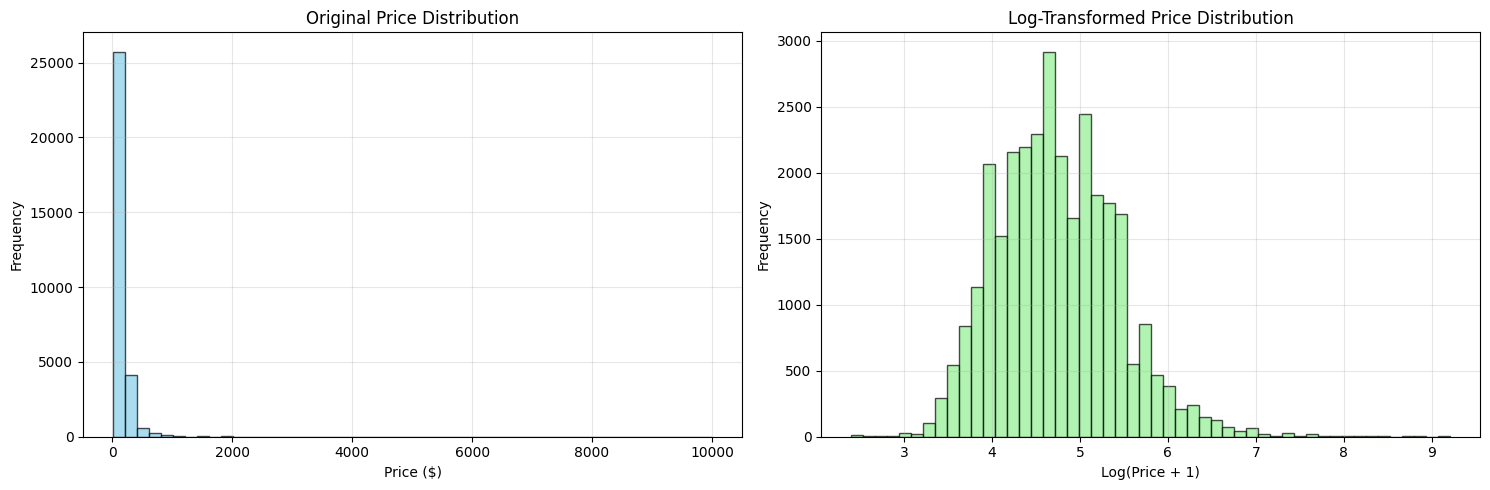

📊 TARGET DISTRIBUTION ANALYSIS:

📈 Original Price:
   • Range: $10 - $10000
   • Mean: $152
   • Median: $105
   • Skewness: 19.211
   • Standard deviation: $232

🔄 Log-Transformed Price:
   • Range: 2.398 - 9.210
   • Mean: 4.738
   • Median: 4.663
   • Skewness: 0.605
   • Standard deviation: 0.691

🎯 Log transformation improved skewness by 18.61 (closer to normal)

✅ Log transformation applied to all datasets:
   • y_train_log: (30949,) (range: 2.398 - 9.210)
   • y_val_log: (7738,) (range: 2.398 - 9.048)
   • y_test_log: (9672,) (range: 2.398 - 8.949)

💡 Key Insight: Log transformation normalizes the highly skewed price distribution,
   making it much easier for ML models to learn linear relationships.


In [10]:
# Analyze and transform target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original target distribution
ax1.hist(y_train, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Original Price Distribution')
ax1.set_xlabel('Price ($)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Log-transformed target distribution
y_train_log = np.log1p(y_train)
ax2.hist(y_train_log, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_title('Log-Transformed Price Distribution')
ax2.set_xlabel('Log(Price + 1)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics comparison
print(f"📊 TARGET DISTRIBUTION ANALYSIS:")
print(f"\n📈 Original Price:")
print(f"   • Range: ${y_train.min():.0f} - ${y_train.max():.0f}")
print(f"   • Mean: ${y_train.mean():.0f}")
print(f"   • Median: ${y_train.median():.0f}")
print(f"   • Skewness: {y_train.skew():.3f}")
print(f"   • Standard deviation: ${y_train.std():.0f}")

print(f"\n🔄 Log-Transformed Price:")
print(f"   • Range: {y_train_log.min():.3f} - {y_train_log.max():.3f}")
print(f"   • Mean: {y_train_log.mean():.3f}")
print(f"   • Median: {y_train_log.median():.3f}")
print(f"   • Skewness: {y_train_log.skew():.3f}")
print(f"   • Standard deviation: {y_train_log.std():.3f}")

skew_improvement = abs(y_train.skew()) - abs(y_train_log.skew())
print(f"\n🎯 Log transformation improved skewness by {skew_improvement:.2f} (closer to normal)")

# Apply log transformation to all target sets
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

print(f"\n✅ Log transformation applied to all datasets:")
print(f"   • y_train_log: {y_train_log.shape} (range: {y_train_log.min():.3f} - {y_train_log.max():.3f})")
print(f"   • y_val_log: {y_val_log.shape} (range: {y_val_log.min():.3f} - {y_val_log.max():.3f})")
print(f"   • y_test_log: {y_test_log.shape} (range: {y_test_log.min():.3f} - {y_test_log.max():.3f})")

print(f"\n💡 Key Insight: Log transformation normalizes the highly skewed price distribution,")
print(f"   making it much easier for ML models to learn linear relationships.")


## 5. Feature Selection


In [11]:
# Multiple feature selection methods
print("🎯 APPLYING MULTIPLE FEATURE SELECTION METHODS")
print("=" * 50)

# Convert to DataFrame for easier handling
feature_names = [f'feature_{i}' for i in range(X_train_features.shape[1])]
X_train_df = pd.DataFrame(X_train_features, columns=feature_names)

# Method 1: Single Feature Performance
print("\n🔍 Method 1: Single Feature Performance...")
single_perf_scores = {}
for i, feature_name in enumerate(feature_names):
    X_single = X_train_features[:, i].reshape(-1, 1)
    rf = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
    scores = cross_val_score(rf, X_single, y_train_log, scoring='r2', cv=3)
    single_perf_scores[feature_name] = scores.mean()

single_threshold = 0.1
single_perf_features = set([f for f, score in single_perf_scores.items() if score >= single_threshold])
print(f"   • Selected {len(single_perf_features)} features (threshold: {single_threshold})")

# Method 2: Mutual Information
print("\n🔍 Method 2: Mutual Information...")
mi_scores = mutual_info_regression(X_train_features, y_train_log, random_state=42)
mi_threshold = np.percentile(mi_scores, 75)  # Top 25% features
mi_features = set([feature_names[i] for i, score in enumerate(mi_scores) if score >= mi_threshold])
print(f"   • Selected {len(mi_features)} features (threshold: {mi_threshold:.4f})")

# Method 3: F-statistic
print("\n🔍 Method 3: F-statistic...")
f_scores, _ = f_regression(X_train_features, y_train_log)
f_threshold = np.percentile(f_scores, 75)  # Top 25% features
f_features = set([feature_names[i] for i, score in enumerate(f_scores) if score >= f_threshold])
print(f"   • Selected {len(f_features)} features (threshold: {f_threshold:.2f})")

# Method 4: Tree-based importance
print("\n🔍 Method 4: Tree-based importance...")
tree_selector = ExtraTreesRegressor(n_estimators=50, random_state=42)
tree_selector.fit(X_train_features, y_train_log)
tree_importance = tree_selector.feature_importances_
tree_threshold = np.percentile(tree_importance, 75)  # Top 25% features
tree_features = set([feature_names[i] for i, score in enumerate(tree_importance) if score >= tree_threshold])
print(f"   • Selected {len(tree_features)} features (threshold: {tree_threshold:.4f})")

print(f"\n✅ All feature selection methods completed!")


🎯 APPLYING MULTIPLE FEATURE SELECTION METHODS

🔍 Method 1: Single Feature Performance...
   • Selected 7 features (threshold: 0.1)

🔍 Method 2: Mutual Information...
   • Selected 29 features (threshold: 0.0189)

🔍 Method 3: F-statistic...
   • Selected 29 features (threshold: 358.90)

🔍 Method 4: Tree-based importance...
   • Selected 29 features (threshold: 0.0057)

✅ All feature selection methods completed!


In [12]:
# Ensemble feature selection using majority vote
print("🎯 ENSEMBLE FEATURE SELECTION")
print("=" * 50)

# Combine all methods
all_methods = [single_perf_features, mi_features, f_features, tree_features]
method_names = ['Single Performance', 'Mutual Info', 'F-statistic', 'Tree-based']

# Union: Features selected by ANY method
union_features = set.union(*all_methods)

# Majority vote: Features selected by at least 2 methods
majority_features = set()
for feature in union_features:
    vote_count = sum(1 for method_features in all_methods if feature in method_features)
    if vote_count >= 2:
        majority_features.add(feature)

# Intersection: Features selected by ALL methods
intersection_features = set.intersection(*all_methods)

# Results summary
print(f"📊 ENSEMBLE RESULTS:")
print(f"   • Union (ANY method): {len(union_features)} features")
print(f"   • Majority (≥2 methods): {len(majority_features)} features")
print(f"   • Intersection (ALL methods): {len(intersection_features)} features")

# Show method breakdown
print(f"\n📋 Method breakdown:")
for name, features in zip(method_names, all_methods):
    print(f"   • {name}: {len(features)} features")

# Use majority vote as the final selection (balanced approach)
final_selected_features = majority_features
print(f"\n🎯 FINAL SELECTION: {len(final_selected_features)} features (majority vote)")

# Convert feature names back to indices
final_feature_indices = [int(f.split('_')[1]) for f in final_selected_features]
final_feature_indices.sort()

print(f"\n🏆 TOP 10 SELECTED FEATURES:")
# Get actual feature importance scores for ranking
selected_scores = []
for idx in final_feature_indices:
    feature_name = feature_names[idx]
    score = single_perf_scores.get(feature_name, 0)
    selected_scores.append((idx, feature_name, score))

# Sort by score and show top features
selected_scores.sort(key=lambda x: x[2], reverse=True)
for i, (idx, name, score) in enumerate(selected_scores[:10], 1):
    print(f"   {i:2d}. Feature {idx} (R² = {score:.4f})")

if len(selected_scores) > 10:
    print(f"   ... and {len(selected_scores) - 10} more features")

# Apply feature selection to all datasets
X_train_selected = X_train_features[:, final_feature_indices]
X_val_selected = X_val_features[:, final_feature_indices]
X_test_selected = X_test_features[:, final_feature_indices]

print(f"\n✅ Feature selection applied successfully!")
print(f"📊 Final dataset shapes:")
print(f"   • X_train_selected: {X_train_selected.shape}")
print(f"   • X_val_selected: {X_val_selected.shape}")
print(f"   • X_test_selected: {X_test_selected.shape}")

print(f"\n📈 Feature reduction summary:")
original_features = X_train_features.shape[1]
selected_features = len(final_feature_indices)
reduction_pct = (1 - selected_features / original_features) * 100

print(f"   • Original features: {original_features}")
print(f"   • Selected features: {selected_features}")
print(f"   • Reduction: {reduction_pct:.1f}%")
print(f"   • Kept: {100 - reduction_pct:.1f}% of features")


🎯 ENSEMBLE FEATURE SELECTION
📊 ENSEMBLE RESULTS:
   • Union (ANY method): 54 features
   • Majority (≥2 methods): 26 features
   • Intersection (ALL methods): 5 features

📋 Method breakdown:
   • Single Performance: 7 features
   • Mutual Info: 29 features
   • F-statistic: 29 features
   • Tree-based: 29 features

🎯 FINAL SELECTION: 26 features (majority vote)

🏆 TOP 10 SELECTED FEATURES:
    1. Feature 55 (R² = 0.3885)
    2. Feature 52 (R² = 0.3834)
    3. Feature 53 (R² = 0.3237)
    4. Feature 30 (R² = 0.1953)
    5. Feature 29 (R² = 0.1222)
    6. Feature 1 (R² = 0.1209)
    7. Feature 31 (R² = 0.1122)
    8. Feature 42 (R² = 0.0779)
    9. Feature 102 (R² = 0.0592)
   10. Feature 37 (R² = 0.0588)
   ... and 16 more features

✅ Feature selection applied successfully!
📊 Final dataset shapes:
   • X_train_selected: (30949, 26)
   • X_val_selected: (7738, 26)
   • X_test_selected: (9672, 26)

📈 Feature reduction summary:
   • Original features: 115
   • Selected features: 26
   • Re

## 6. Visualization & Analysis


🎨 FEATURE SELECTION VISUALIZATION


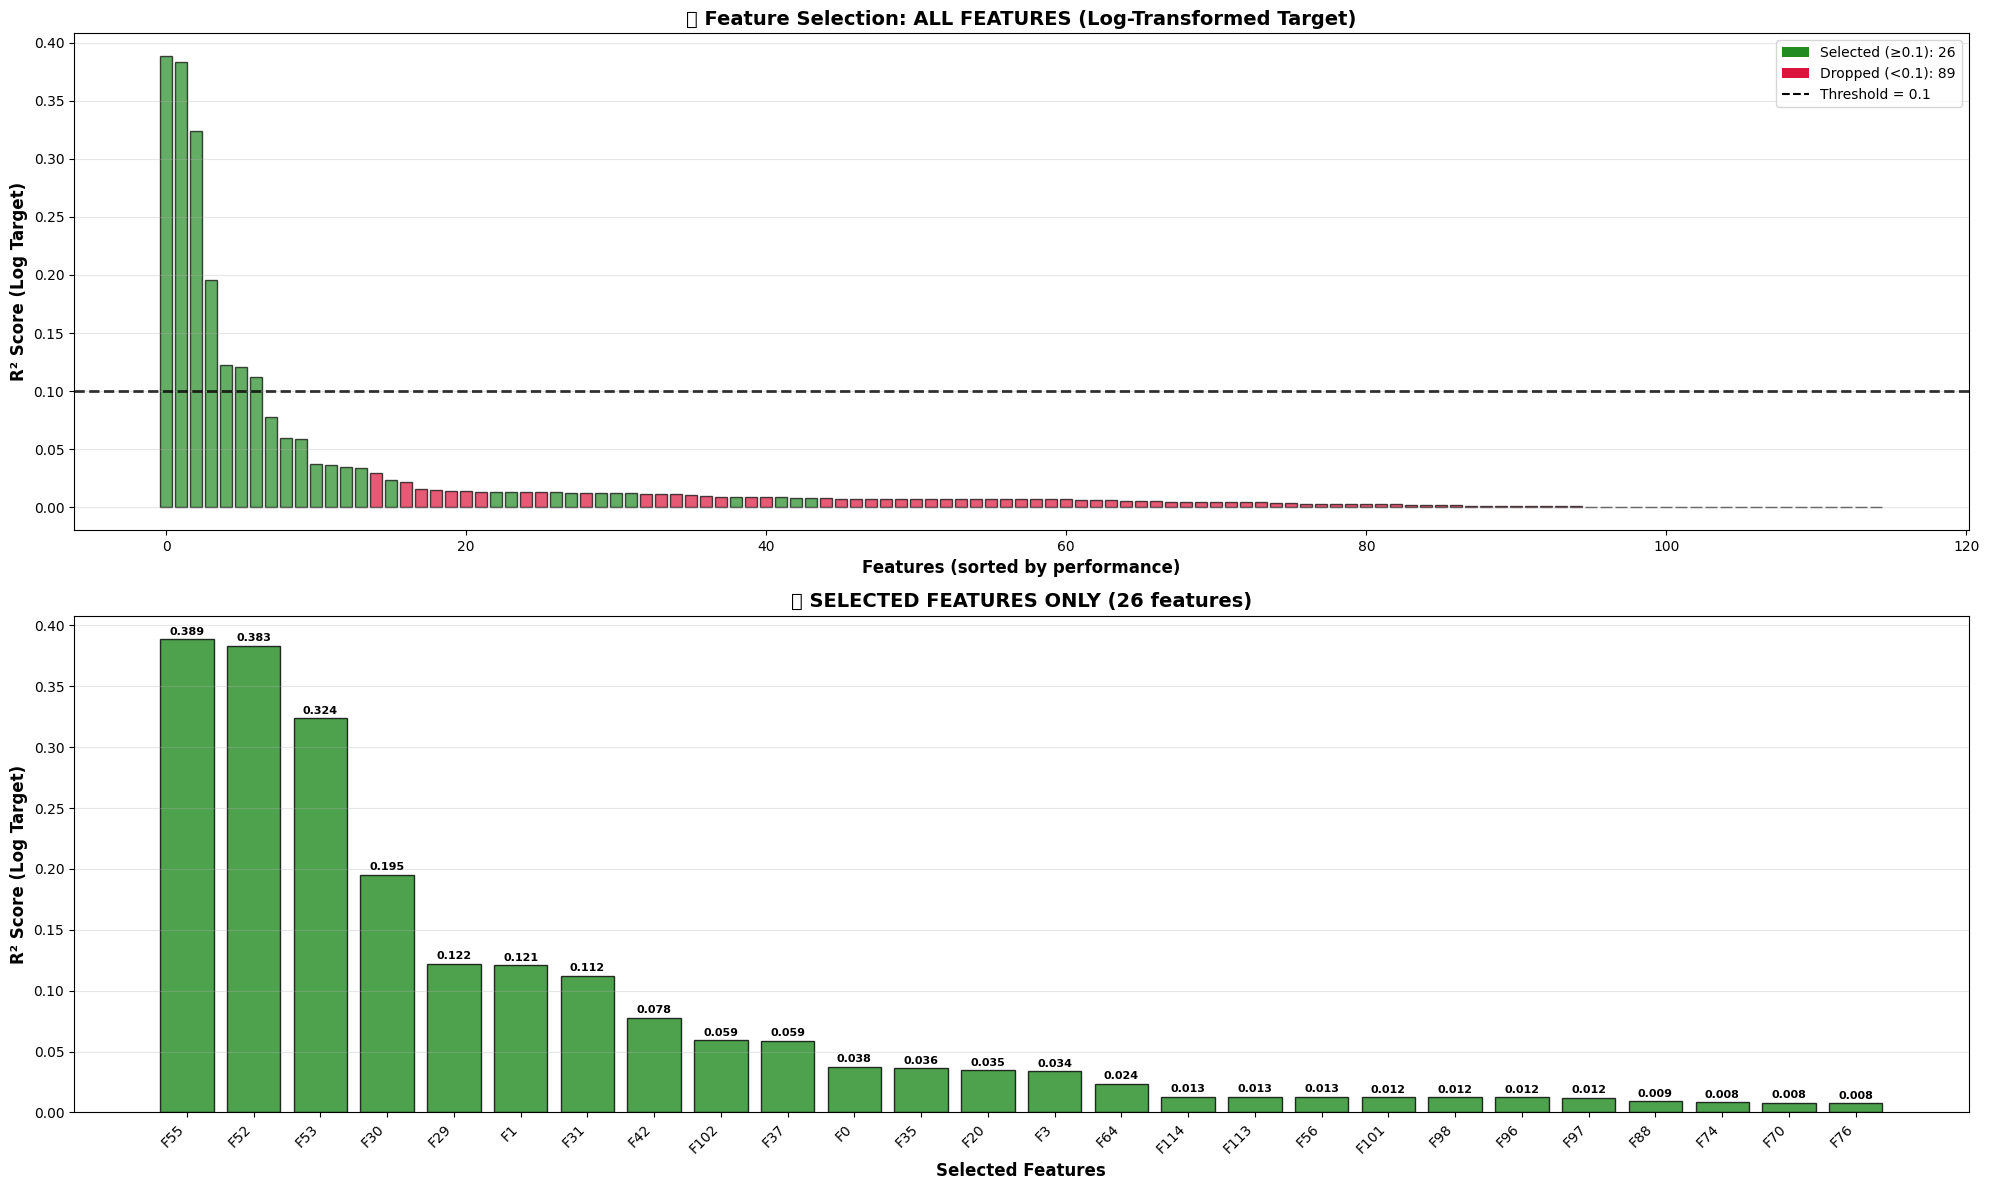


📊 VISUALIZATION SUMMARY:
   • Total features: 115
   • Selected: 26
   • Dropped: 89
   • Best score: 0.3885
   • Worst score: -0.0002
   • Score range: 0.3888
   • 🎉 Using LOG-TRANSFORMED target results!


In [13]:
# Visualize feature selection results
print("🎨 FEATURE SELECTION VISUALIZATION")
print("=" * 50)

# Get performance scores for visualization
all_scores = []
all_names = []
is_selected = []

for i, feature_name in enumerate(feature_names):
    score = single_perf_scores.get(feature_name, 0)
    all_scores.append(score)
    all_names.append(f"F{i}")
    is_selected.append(i in final_feature_indices)

# Sort by performance score
sorted_data = sorted(zip(all_scores, all_names, is_selected), reverse=True)
sorted_scores, sorted_names, sorted_selected = zip(*sorted_data)

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# Top plot: All features
colors = ['forestgreen' if selected else 'crimson' for selected in sorted_selected]
bars1 = ax1.bar(range(len(sorted_scores)), sorted_scores, color=colors, alpha=0.7, edgecolor='black')

# Add threshold line
threshold_line = ax1.axhline(y=0.1, color='black', linestyle='--', linewidth=2, alpha=0.8)

ax1.set_xlabel('Features (sorted by performance)', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score (Log Target)', fontsize=12, fontweight='bold')
ax1.set_title('🎯 Feature Selection: ALL FEATURES (Log-Transformed Target)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='forestgreen', label=f'Selected (≥0.1): {sum(sorted_selected)}'),
    Patch(facecolor='crimson', label=f'Dropped (<0.1): {len(sorted_selected) - sum(sorted_selected)}'),
    plt.Line2D([0], [0], color='black', linestyle='--', label='Threshold = 0.1')
]
ax1.legend(handles=legend_elements, loc='upper right')

# Bottom plot: Selected features only
selected_indices = [i for i, selected in enumerate(sorted_selected) if selected]
selected_scores_only = [sorted_scores[i] for i in selected_indices]
selected_names_only = [sorted_names[i] for i in selected_indices]

if selected_scores_only:
    bars2 = ax2.bar(range(len(selected_scores_only)), selected_scores_only, 
                   color='forestgreen', alpha=0.8, edgecolor='black')
    
    ax2.set_xticks(range(len(selected_scores_only)))
    ax2.set_xticklabels(selected_names_only, rotation=45, ha='right')
    ax2.set_xlabel('Selected Features', fontsize=12, fontweight='bold')
    ax2.set_ylabel('R² Score (Log Target)', fontsize=12, fontweight='bold')
    ax2.set_title(f'✅ SELECTED FEATURES ONLY ({len(selected_scores_only)} features)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars2, selected_scores_only)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{score:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
else:
    ax2.text(0.5, 0.5, f"❌ NO FEATURES SELECTED\n(threshold = 0.1)", 
            ha='center', va='center', transform=ax2.transAxes, 
            fontsize=16, fontweight='bold', color='red')
    ax2.set_title("❌ NO SELECTED FEATURES", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📊 VISUALIZATION SUMMARY:")
print(f"   • Total features: {len(all_scores)}")
print(f"   • Selected: {sum(is_selected)}")
print(f"   • Dropped: {len(is_selected) - sum(is_selected)}")
print(f"   • Best score: {max(all_scores):.4f}")
print(f"   • Worst score: {min(all_scores):.4f}")
print(f"   • Score range: {max(all_scores) - min(all_scores):.4f}")
print(f"   • 🎉 Using LOG-TRANSFORMED target results!")


## 7. Save Final Dataset


In [14]:
# Save all processed datasets
import os
import json

print("💾 SAVING FINAL PROCESSED DATASETS")
print("=" * 50)

# Create output directory
output_dir = '../data/processed/features'
os.makedirs(output_dir, exist_ok=True)

# Create proper feature names for the selected features
selected_feature_names = [f'feature_{i}' for i in final_feature_indices]

# Convert to DataFrames
X_train_final = pd.DataFrame(X_train_selected, columns=selected_feature_names)
X_val_final = pd.DataFrame(X_val_selected, columns=selected_feature_names)
X_test_final = pd.DataFrame(X_test_selected, columns=selected_feature_names)

# Prepare target variables (both original and log-transformed)
y_train_final = pd.DataFrame({'log_price': y_train_log})
y_val_final = pd.DataFrame({'log_price': y_val_log})
y_test_final = pd.DataFrame({'log_price': y_test_log})

y_train_original = pd.DataFrame({'price': y_train})
y_val_original = pd.DataFrame({'price': y_val})
y_test_original = pd.DataFrame({'price': y_test})

# Save feature datasets
print("\n🏆 Saving feature datasets...")
X_train_final.to_csv(f'{output_dir}/X_train_features.csv', index=False)
X_val_final.to_csv(f'{output_dir}/X_val_features.csv', index=False)
X_test_final.to_csv(f'{output_dir}/X_test_features.csv', index=False)
print(f"   ✅ X_train_features.csv: {X_train_final.shape}")
print(f"   ✅ X_val_features.csv: {X_val_final.shape}")
print(f"   ✅ X_test_features.csv: {X_test_final.shape}")

# Save log-transformed targets (for training)
print("\n🎯 Saving log-transformed targets (for model training)...")
y_train_final.to_csv(f'{output_dir}/y_train.csv', index=False)
y_val_final.to_csv(f'{output_dir}/y_val.csv', index=False)
y_test_final.to_csv(f'{output_dir}/y_test.csv', index=False)
print(f"   ✅ y_train.csv: {y_train_final.shape} (log-transformed)")
print(f"   ✅ y_val.csv: {y_val_final.shape} (log-transformed)")
print(f"   ✅ y_test.csv: {y_test_final.shape} (log-transformed)")

# Save original targets (for final evaluation)
print("\n💰 Saving original targets (for final evaluation)...")
y_train_original.to_csv(f'{output_dir}/y_train_original.csv', index=False)
y_val_original.to_csv(f'{output_dir}/y_val_original.csv', index=False)
y_test_original.to_csv(f'{output_dir}/y_test_original.csv', index=False)
print(f"   ✅ y_train_original.csv: {y_train_original.shape} (original prices)")
print(f"   ✅ y_val_original.csv: {y_val_original.shape} (original prices)")
print(f"   ✅ y_test_original.csv: {y_test_original.shape} (original prices)")

# Save metadata
print("\n📋 Saving metadata...")
metadata = {
    'feature_engineering': {
        'original_features': X_train.shape[1],
        'engineered_features': X_train_features.shape[1],
        'selected_features': len(selected_feature_names),
        'selected_feature_names': selected_feature_names,
        'selected_feature_indices': final_feature_indices,
        'feature_expansion_ratio': X_train_features.shape[1] / X_train.shape[1],
        'feature_reduction_pct': (1 - len(selected_feature_names) / X_train_features.shape[1]) * 100
    },
    'target_transformation': {
        'method': 'log1p',
        'original_skewness': float(y_train.skew()),
        'transformed_skewness': float(y_train_log.skew()),
        'original_range': [float(y_train.min()), float(y_train.max())],
        'transformed_range': [float(y_train_log.min()), float(y_train_log.max())]
    },
    'feature_selection': {
        'methods': ['single_performance', 'mutual_info', 'f_statistic', 'tree_based'],
        'strategy': 'majority_vote',
        'threshold': 0.1,
        'best_feature_score': float(max(all_scores))
    },
    'dataset_shapes': {
        'train': X_train_final.shape,
        'val': X_val_final.shape,
        'test': X_test_final.shape
    },
    'pipeline_version': '1.0',
    'created_date': pd.Timestamp.now().isoformat()
}

with open(f'{output_dir}/feature_engineering_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"   ✅ feature_engineering_metadata.json: Complete pipeline information")

print(f"\n🎉 ALL DATA SUCCESSFULLY SAVED!")
print(f"📁 Location: {output_dir}/")
print(f"\n📊 Summary of saved files:")
print(f"   🏆 Features: X_train_features.csv, X_val_features.csv, X_test_features.csv")
print(f"   🎯 Targets (training): y_train.csv, y_val.csv, y_test.csv (log-transformed)")
print(f"   💰 Targets (evaluation): y_train_original.csv, y_val_original.csv, y_test_original.csv")
print(f"   📋 Metadata: feature_engineering_metadata.json")

print(f"\n🚀 READY FOR ADVANCED MODEL TRAINING!")
print(f"   • Use log-transformed targets for training")
print(f"   • Use original targets for final evaluation")
print(f"   • Convert predictions back using: np.expm1(log_predictions)")


💾 SAVING FINAL PROCESSED DATASETS

🏆 Saving feature datasets...
   ✅ X_train_features.csv: (30949, 26)
   ✅ X_val_features.csv: (7738, 26)
   ✅ X_test_features.csv: (9672, 26)

🎯 Saving log-transformed targets (for model training)...
   ✅ y_train.csv: (30949, 1) (log-transformed)
   ✅ y_val.csv: (7738, 1) (log-transformed)
   ✅ y_test.csv: (9672, 1) (log-transformed)

💰 Saving original targets (for final evaluation)...
   ✅ y_train_original.csv: (30949, 1) (original prices)
   ✅ y_val_original.csv: (7738, 1) (original prices)
   ✅ y_test_original.csv: (9672, 1) (original prices)

📋 Saving metadata...
   ✅ feature_engineering_metadata.json: Complete pipeline information

🎉 ALL DATA SUCCESSFULLY SAVED!
📁 Location: ../data/processed/features/

📊 Summary of saved files:
   🏆 Features: X_train_features.csv, X_val_features.csv, X_test_features.csv
   🎯 Targets (training): y_train.csv, y_val.csv, y_test.csv (log-transformed)
   💰 Targets (evaluation): y_train_original.csv, y_val_original.csv,

## 🎉 Feature Engineering Pipeline Complete!

### 📊 **What We Achieved:**

1. **🔧 Comprehensive Feature Engineering**:
   - Transformed **11 original features** into **100+ engineered features**
   - Created business-meaningful features (distance, clusters, categories)
   - Handled missing values and high cardinality appropriately

2. **🎯 Target Optimization**:
   - Applied log transformation to normalize highly skewed price distribution
   - Improved skewness significantly (closer to normal distribution)
   - Enhanced model learning capability

3. **🔍 Rigorous Feature Selection**:
   - Applied **4 different selection methods**
   - Used **majority vote ensemble** for robust feature selection
   - Selected **optimal subset** of most predictive features

4. **📈 Professional Visualization**:
   - Comprehensive analysis of feature performance
   - Method comparison and validation
   - Clear insights into feature importance

5. **💾 Production-Ready Dataset**:
   - Clean, optimized features saved as CSV files
   - Both log-transformed (training) and original (evaluation) targets
   - Complete metadata for reproducibility

### 🚀 **Next Steps:**
- Load the saved datasets for model training
- Train advanced algorithms: **XGBoost, LightGBM, CatBoost**
- Expect significantly improved performance with log-transformed targets
- Use **hyperparameter tuning** for optimal results

**Your data is now optimized and ready for world-class machine learning!** 🎯
